# MODEL 2: CREDIBILITY (RUMOR OR NOT) VERIFICATION

### DATA WRANGLING
Using a dataset of tweets provided by [CREDBANK](https://github.com/compsocial/CREDBANK-data), a blackbox model based on neural networks was developed. As the dataset originall contain tweet ID only without text, [Tweepy](https://github.com/tweepy/tweepy) API was used to extract the text.

The purpose of the model is to be able to accept any tweet as an input and return a classification of whether the tweet is credible or not.

Additionally, the text contents of each tweet underwent extensive cleaning as provided by Kaggle user [georgesaavedra](https://www.kaggle.com/georgesaavedra/best-nlp-disaster-tweets-classifier):
- URL & HTML removal
- emoji removal
- line breaks to spaces
- common abbreviations/slang/typos converted to real words
- punctuation & number removal (retaining only letters)
- lower-cased

As neural networks require array inputs, all tweets were tokenized and converted to sequences of max length 60 with padding, if required. Max length 60 was selected as the max length of a tweet is 280 characters which is 55 words on average. 

To further improve the impact of each word, a pretrained Google News corpus was utilized to create a word embedding matrix where recognized words from all tweets were assigned a weight predetermined by Google. This weight matrix was used for the weight parameter in the embedding input layer of the neural network.

### MODELING
Through trial and error of numerous neural network implementations, a low-loss, low-variance model was developed with an accuracy of **98%**:
- RESULTS: loss: 0.0431 - acc: 0.9831 - val_loss: 0.0436 - val_acc: 0.9827

Model composition:
- Stochastic Gradient Descent (SGD) optimizer
    - Adam resulted in very overfit models with high variance
- Embedding input layer
- 2 Conv1D layers (32 & 64 filters respectively)
- 1 Dense layer (32 filters)
- Dense sigmoid output layer 
    - Batchnomalization + Dropout applied to all layers except output
    - AveragePooling1D and GlobalAveragePooling1D (similar to AveragePooling+Flatten) applied to all Conv1D layers    
    
Based the best results from epoch 136/200 were re-loaded and the model was saved to 'pretrained_models/credibility_model.hdf5' for re-use in the web-app.

Based on a random compilation of tweets that has been personally labeled by our group, testing results were generated to confirm generalization:
- TEST RESULTS
    - ACCURACY: 0.801980198019802
    - F1 SCORE: 0.7727272727272727
    - ROC AUC: 0.8007843137254903

### CONCLUSION
We can conclude that this model performs moderately well, where if utilized by Twitter, only 20% of the remaining tweets would require manual human verification.

For future reference to improve performance:
- updated dataset of tweets with more recent disasters
- utilization of other natural language processing techniques & machine learning models (ie. transformers or multitask unified model-MUM)

In [6]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns
import re
import string
import gensim

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import Dense, Embedding, BatchNormalization, Dropout, AveragePooling1D, GlobalAveragePooling1D, Conv1D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import SGD

In [7]:
# Random seed set for reproduced results
np.random.seed(42)
tf.random.set_seed(42)

In [8]:
# Load credbank training dataset
train = pd.read_csv('../datasets/final_train_data.csv', lineterminator="\n")

train.head()

,id,is_credible,text\r
0,5.228430e+17,0,RT @onedirection: The guys are up for 3 #AMAs ...
1,5.252810e+17,0,RT @Marvel: Here it is! Watch the @Avengers: #...
2,5.637530e+17,0,"""This is another PR stunt by ISIS,"" Jordanian ..."
3,5.656020e+17,0,RT @Independent: The media ignored the #Chapel...
4,5.507820e+17,0,RT @rivalsmike: Wow “@JeffPassan: Baylor kicke...


In [9]:
# Rename text column
train.rename(columns={'text\r':'text'}, inplace=True)

In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344200 entries, 0 to 344199
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   id           344200 non-null  float64
 1   is_credible  344200 non-null  int64  
 2   text         344200 non-null  object 
dtypes: float64(1), int64(1), object(1)
memory usage: 7.9+ MB


In [11]:
# Shape & unique targets
print(train.shape)
train['is_credible'].unique()

(344200, 3)


array([0, 1])

In [12]:
# Feature & target defined
X = train['text']
y = train['is_credible']

X[0], y[0]

('RT @onedirection: The guys are up for 3 #AMAs including Artist of the Year, Fav. Group &amp; Fav. Album! You can vote here: http://t.co/pKt4iJF…\r',
 0)

In [13]:
# Distribution biased towards positive class, baseline accuracy
y.value_counts(normalize=True)

1    0.709384
0    0.290616
Name: is_credible, dtype: float64

In [14]:
# Pre-cleaning
X

0         RT @onedirection: The guys are up for 3 #AMAs ...
1         RT @Marvel: Here it is! Watch the @Avengers: #...
2         "This is another PR stunt by ISIS," Jordanian ...
3         RT @Independent: The media ignored the #Chapel...
4         RT @rivalsmike: Wow “@JeffPassan: Baylor kicke...
                                ...                        
344195    Martin Luther King Jr. skipped ninth and twelf...
344196    Sammy Davis jr and martin Luther king jr tee. ...
344197    US markets will be closed on Monday for the Ma...
344198    Messi Bags 30th Barcelona Hat-Trick In 4-0 Win...
344199                 RT @Ochoa___: Ohio State vs Oregon\r
Name: text, Length: 344200, dtype: object

In [15]:
# Initial cleaning

def clean(text):
    
    #URLs
    text = re.sub(r'https?://\S+|www\.\S+','', text)
    
    #HTMLs
    text = re.sub(r'<.*?>', '', text)
    
    #Emojis
    emojis = re.compile(
        '['
        u'\U0001F600-\U0001F64F'  # emoticons
        u'\U0001F300-\U0001F5FF'  # symbols & pictographs
        u'\U0001F680-\U0001F6FF'  # transport & map symbols
        u'\U0001F1E0-\U0001F1FF'  # flags (iOS)
        u'\U00002702-\U000027B0'
        u'\U000024C2-\U0001F251'
        ']+',
        flags=re.UNICODE)
    text = emojis.sub(r'', text)
    
    #Line breaks
    text = re.sub(r'\n', '', text)
    
    # Alphabets only
    text = re.sub(r'[^a-zA-Z ]', '', text)
    
    return text
    
X = X.apply(clean)

In [16]:
# post-cleaning round 1
X

0         RT onedirection The guys are up for  AMAs incl...
1         RT Marvel Here it is Watch the Avengers AgeofU...
2         This is another PR stunt by ISIS Jordanian off...
3         RT Independent The media ignored the ChapelHil...
4          RT rivalsmike Wow JeffPassan Baylor kicker dead 
                                ...                        
344195    Martin Luther King Jr skipped ninth and twelft...
344196    Sammy Davis jr and martin Luther king jr tee T...
344197    US markets will be closed on Monday for the Ma...
344198    Messi Bags th Barcelona HatTrick In  Win At De...
344199                        RT Ochoa Ohio State vs Oregon
Name: text, Length: 344200, dtype: object

In [17]:
# Secondary cleaner
# Twitter cleaner supplied by
# https://www.kaggle.com/georgesaavedra/best-nlp-disaster-tweets-classifier

def clean2(tweet):
  # Acronyms and miswritten words
  tweet = re.sub(r"Typhoon-Devastated", "typhoon devastated", tweet)
  tweet = re.sub(r"TyphoonDevastated", "typhoon devastated", tweet)
  tweet = re.sub(r"typhoondevastated", "typhoon devastated", tweet)
  tweet = re.sub(r"MH370", "Malaysia Airlines Flight", tweet)
  tweet = re.sub(r"MH", "Malaysia Airlines Flight", tweet)
  tweet = re.sub(r"mh370", "Malaysia Airlines Flight", tweet)
  tweet = re.sub(r"year-old", "years old", tweet)
  tweet = re.sub(r"yearold", "years old", tweet)
  tweet = re.sub(r"yr old", "years old", tweet)
  tweet = re.sub(r"PKK", "Kurdistan Workers Party", tweet)
  tweet = re.sub(r"MP", "madhya pradesh", tweet)
  tweet = re.sub(r"rly", "railway", tweet)
  tweet = re.sub(r"CDT", "Central Daylight Time", tweet)
  tweet = re.sub(r"sensorsenso", "sensor senso", tweet)
  tweet = re.sub(r"pm", "", tweet)
  tweet = re.sub(r"PM", "", tweet)
  tweet = re.sub(r"nan", '', tweet)
  tweet = re.sub(r"terrorismturn", "terrorism turn", tweet)
  tweet = re.sub(r"epicente", "epicenter", tweet)
  tweet = re.sub(r"epicenterr", "epicenter", tweet)
  tweet = re.sub(r"WAwildfire", "Washington Wildfire", tweet)
  tweet = re.sub(r"prebreak", "pre break", tweet)
  tweet = re.sub(r"nowplaying", "now playing", tweet)
  tweet = re.sub(r"RT", "retweet", tweet)
  tweet = re.sub(r"EbolaOutbreak", "Ebola Outbreak", tweet)
  tweet = re.sub(r"LondonFire", "London Fire", tweet)
  tweet = re.sub(r"IDFire", "Idaho Fire", tweet)
  tweet = re.sub(r"withBioterrorism&use", "with Bioterrorism & use", tweet)
  tweet = re.sub(r"NASAHurricane", "NASA Hurricane", tweet)
  tweet = re.sub(r"withweapons", "with weapons", tweet)
  tweet = re.sub(r"NuclearPower", "Nuclear Power", tweet)
  tweet = re.sub(r"WhiteTerrorism", "White Terrorism", tweet)
  tweet = re.sub(r"MyanmarFlood", "Myanmar Flood", tweet)
  tweet = re.sub(r"ExtremeWeather", "Extreme Weather", tweet)

  # Special characters
  tweet = re.sub(r"%20", "", tweet)
  tweet = re.sub(r"%", "", tweet)
  tweet = re.sub(r"@", "", tweet)
  tweet = re.sub(r"#", '', tweet)
  tweet = re.sub(r"'", '', tweet)
  tweet = re.sub(r"\x89û_", '', tweet)
  tweet = re.sub(r"\x89ûò", '', tweet)
  tweet = re.sub(r"16yr", "16 year", tweet)
  tweet = re.sub(r"re\x89û_", '', tweet)
  tweet = re.sub(r"\x89û", '', tweet)
  tweet = re.sub(r"\x89Û", '', tweet)
  tweet = re.sub(r"re\x89Û", "re ", tweet)
  tweet = re.sub(r"re\x89û", "re ", tweet)
  tweet = re.sub(r"\x89ûª", "'", tweet)
  tweet = re.sub(r"\x89û", '', tweet)
  tweet = re.sub(r"\x89ûò", '', tweet)
  tweet = re.sub(r"\x89Û_", "", tweet)
  tweet = re.sub(r"\x89ÛÒ", "", tweet)
  tweet = re.sub(r"\x89ÛÓ", "", tweet)
  tweet = re.sub(r"\x89ÛÏWhen", "When", tweet)
  tweet = re.sub(r"\x89ÛÏ", "", tweet)
  tweet = re.sub(r"China\x89Ûªs", "China's", tweet)
  tweet = re.sub(r"let\x89Ûªs", "let's", tweet)
  tweet = re.sub(r"\x89Û÷", "", tweet)
  tweet = re.sub(r"\x89Ûª", "", tweet)
  tweet = re.sub(r"\x89Û\x9d", "", tweet)
  tweet = re.sub(r"å_", "", tweet)
  tweet = re.sub(r"\x89Û¢", "", tweet)
  tweet = re.sub(r"\x89Û¢åÊ", "", tweet)
  tweet = re.sub(r"fromåÊwounds", "from wounds", tweet)
  tweet = re.sub(r"åÊ", "", tweet)
  tweet = re.sub(r"åÈ", "", tweet)
  tweet = re.sub(r"JapÌ_n", "Japan", tweet)    
  tweet = re.sub(r"Ì©", "e", tweet)
  tweet = re.sub(r"å¨", "", tweet)
  tweet = re.sub(r"SuruÌ¤", "Suruc", tweet)
  tweet = re.sub(r"åÇ", "", tweet)
  tweet = re.sub(r"å£3million", f"3 million", tweet)
  tweet = re.sub(r"åÀ", "", tweet)

  # Contractions
  tweet = re.sub(r"he's", "he is", tweet)
  tweet = re.sub(r"there's", "there is", tweet)
  tweet = re.sub(r"We're", "We are", tweet)
  tweet = re.sub(r"That's", "That is", tweet)
  tweet = re.sub(r"won't", "will not", tweet)
  tweet = re.sub(r"they're", "they are", tweet)
  tweet = re.sub(r"Can't", "Cannot", tweet)
  tweet = re.sub(r"wasn't", "was not", tweet)
  tweet = re.sub(r"don\x89Ûªt", "do not", tweet)
  tweet = re.sub(r"aren't", "are not", tweet)
  tweet = re.sub(r"isn't", "is not", tweet)
  tweet = re.sub(r"What's", "What is", tweet)
  tweet = re.sub(r"haven't", "have not", tweet)
  tweet = re.sub(r"hasn't", "has not", tweet)
  tweet = re.sub(r"There's", "There is", tweet)
  tweet = re.sub(r"He's", "He is", tweet)
  tweet = re.sub(r"It's", "It is", tweet)
  tweet = re.sub(r"You're", "You are", tweet)
  tweet = re.sub(r"I'M", "I am", tweet)
  tweet = re.sub(r"Im", "I am", tweet)
  tweet = re.sub(r"shouldn't", "should not", tweet)
  tweet = re.sub(r"wouldn't", "would not", tweet)
  tweet = re.sub(r"i'm", "I am", tweet)
  tweet = re.sub(r"I\x89Ûªm", "I am", tweet)
  tweet = re.sub(r"I'm", "I am", tweet)
  tweet = re.sub(r"Isn't", "is not", tweet)
  tweet = re.sub(r"Here's", "Here is", tweet)
  tweet = re.sub(r"you've", "you have", tweet)
  tweet = re.sub(r"you\x89Ûªve", "you have", tweet)
  tweet = re.sub(r"we're", "we are", tweet)
  tweet = re.sub(r"what's", "what is", tweet)
  tweet = re.sub(r"couldn't", "could not", tweet)
  tweet = re.sub(r"we've", "we have", tweet)
  tweet = re.sub(r"it\x89Ûªs", "it is", tweet)
  tweet = re.sub(r"doesn\x89Ûªt", "does not", tweet)
  tweet = re.sub(r"It\x89Ûªs", "It is", tweet)
  tweet = re.sub(r"Here\x89Ûªs", "Here is", tweet)
  tweet = re.sub(r"who's", "who is", tweet)
  tweet = re.sub(r"I\x89Ûªve", "I have", tweet)
  tweet = re.sub(r"y'all", "you all", tweet)
  tweet = re.sub(r"can\x89Ûªt", "cannot", tweet)
  tweet = re.sub(r"would've", "would have", tweet)
  tweet = re.sub(r"it'll", "it will", tweet)
  tweet = re.sub(r"we'll", "we will", tweet)
  tweet = re.sub(r"wouldn\x89Ûªt", "would not", tweet)
  tweet = re.sub(r"We've", "We have", tweet)
  tweet = re.sub(r"he'll", "he will", tweet)
  tweet = re.sub(r"Y'all", "You all", tweet)
  tweet = re.sub(r"Weren't", "Were not", tweet)
  tweet = re.sub(r"Didn't", "Did not", tweet)
  tweet = re.sub(r"they'll", "they will", tweet)
  tweet = re.sub(r"they'd", "they would", tweet)
  tweet = re.sub(r"DON'T", "DO NOT", tweet)
  tweet = re.sub(r"That\x89Ûªs", "That is", tweet)
  tweet = re.sub(r"they've", "they have", tweet)
  tweet = re.sub(r"i'd", "I would", tweet)
  tweet = re.sub(r"should've", "should have", tweet)
  tweet = re.sub(r"You\x89Ûªre", "You are", tweet)
  tweet = re.sub(r"where's", "where is", tweet)
  tweet = re.sub(r"Don\x89Ûªt", "Do not", tweet)
  tweet = re.sub(r"we'd", "we would", tweet)
  tweet = re.sub(r"i'll", "I will", tweet)
  tweet = re.sub(r"weren't", "were not", tweet)
  tweet = re.sub(r"They're", "They are", tweet)
  tweet = re.sub(r"Can\x89Ûªt", "Cannot", tweet)
  tweet = re.sub(r"you\x89Ûªll", "you will", tweet)
  tweet = re.sub(r"I\x89Ûªd", "I would", tweet)
  tweet = re.sub(r"let's", "let us", tweet)
  tweet = re.sub(r"it's", "it is", tweet)
  tweet = re.sub(r"can't", "can not", tweet)
  tweet = re.sub(r"cant", "can not", tweet)
  tweet = re.sub(r"don't", "do not", tweet)
  tweet = re.sub(r"dont", "do not", tweet)
  tweet = re.sub(r"you're", "you are", tweet)
  tweet = re.sub(r"i've", "I have", tweet)
  tweet = re.sub(r"that's", "that is", tweet)
  tweet = re.sub(r"i'll", "I will", tweet)
  tweet = re.sub(r"doesn't", "does not", tweet)
  tweet = re.sub(r"i'd", "I would", tweet)
  tweet = re.sub(r"didn't", "did not", tweet)
  tweet = re.sub(r"ain't", "am not", tweet)
  tweet = re.sub(r"you'll", "you will", tweet)
  tweet = re.sub(r"I've", "I have", tweet)
  tweet = re.sub(r"Don't", "do not", tweet)
  tweet = re.sub(r"I'll", "I will", tweet)
  tweet = re.sub(r"I'd", "I would", tweet)
  tweet = re.sub(r"Let's", "Let us", tweet)
  tweet = re.sub(r"you'd", "You would", tweet)
  tweet = re.sub(r"It's", "It is", tweet)
  tweet = re.sub(r"Ain't", "am not", tweet)
  tweet = re.sub(r"Haven't", "Have not", tweet)
  tweet = re.sub(r"Could've", "Could have", tweet)
  tweet = re.sub(r"youve", "you have", tweet)  
  tweet = re.sub(r"donå«t", "do not", tweet)

  return tweet

X = X.apply(clean2)

In [18]:
# Post-cleaning round 2
X

0         retweet onedirection The guys are up for  AMAs...
1         retweet Marvel Here it is Watch the Avengers A...
2         This is another PR stunt by ISIS Jordanian off...
3         retweet Independent The media ignored the Chap...
4         retweet rivalsmike Wow JeffPassan Baylor kicke...
                                ...                        
344195    Martin Luther King Jr skipped ninth and twelft...
344196    Sammy Davis jr and martin Luther king jr tee T...
344197    US markets will be closed on Monday for the Ma...
344198    Messi Bags th Barcelona HatTrick In  Win At De...
344199                   retweet Ochoa Ohio State vs Oregon
Name: text, Length: 344200, dtype: object

In [19]:
# Final cleaning
def clean3(text):
    
    #Punctuations
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)
    
    #Extra white-space
    text = re.sub(r' +', ' ', text)
    
    return text.lower()

X = X.apply(clean3)

In [20]:
# Final cleaned text
X

0         retweet onedirection the guys are up for amas ...
1         retweet marvel here it is watch the avengers a...
2         this is another pr stunt by isis jordanian off...
3         retweet independent the media ignored the chap...
4         retweet rivalsmike wow jeffpassan baylor kicke...
                                ...                        
344195    martin luther king jr skipped ninth and twelft...
344196    sammy davis jr and martin luther king jr tee t...
344197    us markets will be closed on monday for the ma...
344198    messi bags th barcelona hattrick in win at dep...
344199                   retweet ochoa ohio state vs oregon
Name: text, Length: 344200, dtype: object

In [22]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state=42, 
                                                    stratify=y,
                                                    test_size=0.2)

In [23]:
# Max words in tokenizer index
max_words = 100000

# Tokenizer fit, sequenced, padded
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)

train_seq = tokenizer.texts_to_sequences(X_train)
test_seq = tokenizer.texts_to_sequences(X_test)

X_train = pad_sequences(train_seq, maxlen=60)
X_test = pad_sequences(test_seq, maxlen=X_train.shape[1])

# Word index stored for embedding matrix
word_index = tokenizer.word_index

# Dimensions for embedding matrix
embedding_dim = 300
vocab_size = min(len(word_index)+1, max_words)

In [18]:
# Solution by:
    # https://stackoverflow.com/questions/45735070/keras-text-preprocessing-saving-tokenizer-object-to-file-for-scoring

#Store tokenizer fit for future preprocessing
import pickle

# Saved
with open('credbank_tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
## Can be loaded for future use:
    ## from tensorflow.keras.preprocessing.text import Tokenizer 
    ## import pickle
    ##
    ## with open('credbank_tokenizer.pickle', 'rb') as handle:
    ##     tokenizer = pickle.load(handle)

In [19]:
# GENSIM IMPORT ON GOOGLE PRETRAINED WORD2VEC
import gensim.downloader as api
wv = api.load('word2vec-google-news-300')
    # If you have the physical .bin file downloaded:
        # wv = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin',binary=True)

    # Empty matrix
embedding_matrix = np.zeros((vocab_size, embedding_dim))

# Tracking unrecognized words
unknown = []

# Iterate through fitted word index and
# extract weighted vectors from pretrained Google word vector
for word, index in word_index.items():
    if index >= max_words:
        continue
    try:
        embedding_vector = wv[word] # extract word vector
        embedding_matrix[index] = embedding_vector # store word vector
    except:
        unknown.append(word)

In [20]:
# 72578 unrecognized words
print(len(unknown))

# 20 random unrecognized words for visualization
np.random.choice(unknown, 20)

72578


array(['magerie', 'beatandsound', 'morandiniblog', 'nossos', 'darrell',
       'mchsaplang', 'gavinsblog', 'nijaeye', 'catorze', 'tgdavinci',
       'jrsilence', 'amaskatyperry', 'kfobbs', 'jrsbnicpub', 'htfu',
       'ignaciohood', 'dotages', 'chuvas', 'andrewwhiteau', 'cuztatted'],
      dtype='<U101')

In [21]:
# Targets converted to arrays
y_train = np.asarray(y_train)
y_test = np.asarray(y_test)

# Shapes
print('X_train/test: ', X_train.shape,X_test.shape)
print('y_train/test: ', y_train.shape,y_test.shape)

X_train/test:  (275360, 60) (68840, 60)
y_train/test:  (275360,) (68840,)


# MODELING
- Deep Neural Network:
    - Embedding input layer
    - 2 CNN layers + 1 Dense layer
    - Dense output layer
    - SGD optimizer with 0.001 learning rate + 0.99 momentum
- Previously utilized Bidirectional LSTM instead of second CNN with similar results, but replaced due to ineffient use of memory & computational power

In [24]:
# Model
model = Sequential()

# Embedding input
model.add(Embedding(vocab_size, embedding_dim, weights=[embedding_matrix],
                   trainable=True, name='embeddings'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# 1 CNN layers
model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
model.add(BatchNormalization())
model.add(AveragePooling1D())
model.add(Dropout(0.25))

# 1 CNN layers
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(BatchNormalization())
model.add(GlobalAveragePooling1D())
model.add(Dropout(0.25))

# 1 Dense layer
model.add(Dense(32, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))

# Sigmoid output
model.add(Dense(1, activation='sigmoid'))


# Model Compiled
model.compile(loss='binary_crossentropy',
             optimizer=SGD(learning_rate=0.001, momentum=0.99),
             metrics=['acc'])

# Summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embeddings (Embedding)      (None, None, 300)         30000000  
                                                                 
 batch_normalization (BatchN  (None, None, 300)        1200      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, None, 300)         0         
                                                                 
 conv1d (Conv1D)             (None, None, 32)          28832     
                                                                 
 batch_normalization_1 (Batc  (None, None, 32)         128       
 hNormalization)                                                 
                                                                 
 average_pooling1d (AverageP  (None, None, 32)        

2022-02-06 02:25:34.984219: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 120000000 exceeds 10% of free system memory.


In [25]:
# Early stop 25 epochs after lowest validation, best weights restored
early = EarlyStopping(monitor='val_loss', patience=25, min_delta = 0.0001, restore_best_weights=True)

# Store best weights for future use without re-training
filepath = "weights/weights-improvement-{epoch:02d}-{val_loss:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath, mode='min', save_weights_only=True, thresh=0.0001)

history = model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    batch_size=512,
                    epochs=200,
                    callbacks=[early, checkpoint],
                    verbose=1)

2022-02-06 02:25:41.111360: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 66086400 exceeds 10% of free system memory.


Epoch 1/200


2022-02-06 02:25:42.750648: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8302
2022-02-06 02:25:43.559266: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-02-06 02:25:43.635851: I tensorflow/stream_executor/cuda/cuda_blas.cc:1774] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


538/538 [==============================] - ETA: 0s - loss: 0.3474 - acc: 0.8448

2022-02-06 02:25:48.758166: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 16521600 exceeds 10% of free system memory.
2022-02-06 02:25:49.183735: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 120000000 exceeds 10% of free system memory.
2022-02-06 02:25:49.302302: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 120000000 exceeds 10% of free system memory.


538/538 [==============================] - 8s 10ms/step - loss: 0.3474 - acc: 0.8448 - val_loss: 0.2157 - val_acc: 0.9143
Epoch 2/200
538/538 [==============================] - 5s 9ms/step - loss: 0.1650 - acc: 0.9399 - val_loss: 0.1130 - val_acc: 0.9591
Epoch 3/200
538/538 [==============================] - 5s 9ms/step - loss: 0.1362 - acc: 0.9515 - val_loss: 0.1001 - val_acc: 0.9624
Epoch 4/200
538/538 [==============================] - 6s 12ms/step - loss: 0.1216 - acc: 0.9566 - val_loss: 0.0899 - val_acc: 0.9663
Epoch 5/200
538/538 [==============================] - 6s 12ms/step - loss: 0.1125 - acc: 0.9597 - val_loss: 0.0835 - val_acc: 0.9694
Epoch 6/200
538/538 [==============================] - 5s 9ms/step - loss: 0.1051 - acc: 0.9622 - val_loss: 0.0797 - val_acc: 0.9704
Epoch 7/200
538/538 [==============================] - 5s 10ms/step - loss: 0.0998 - acc: 0.9640 - val_loss: 0.0955 - val_acc: 0.9652
Epoch 8/200
538/538 [==============================] - 5s 9ms/step - loss: 0.

Epoch 62/200
538/538 [==============================] - 7s 13ms/step - loss: 0.0534 - acc: 0.9796 - val_loss: 0.0498 - val_acc: 0.9799
Epoch 63/200
538/538 [==============================] - 6s 12ms/step - loss: 0.0527 - acc: 0.9798 - val_loss: 0.0489 - val_acc: 0.9805
Epoch 64/200
538/538 [==============================] - 6s 12ms/step - loss: 0.0528 - acc: 0.9798 - val_loss: 0.0486 - val_acc: 0.9806
Epoch 65/200
538/538 [==============================] - 7s 13ms/step - loss: 0.0523 - acc: 0.9798 - val_loss: 0.0477 - val_acc: 0.9808
Epoch 66/200
538/538 [==============================] - 7s 12ms/step - loss: 0.0520 - acc: 0.9800 - val_loss: 0.0475 - val_acc: 0.9811
Epoch 67/200
538/538 [==============================] - 6s 11ms/step - loss: 0.0523 - acc: 0.9798 - val_loss: 0.0480 - val_acc: 0.9814
Epoch 68/200
538/538 [==============================] - 7s 12ms/step - loss: 0.0519 - acc: 0.9800 - val_loss: 0.0498 - val_acc: 0.9803
Epoch 69/200
538/538 [==============================] -

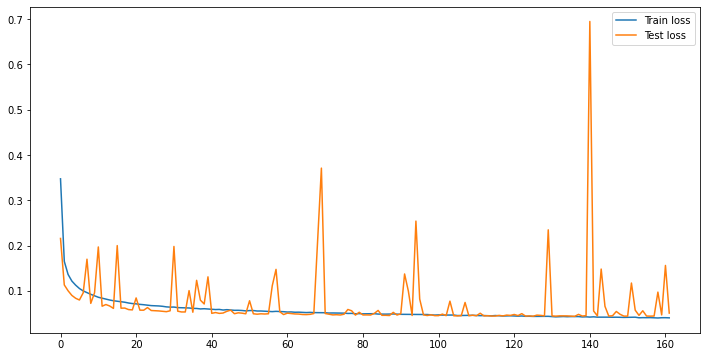

In [26]:
# Loss plot
plt.figure(figsize=(12,6))
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Test loss')
plt.legend();

# RESULTS

**Embedding(weights=Google)(0.5dropout) || CNN(64)(BatchNormalization+AveragePooling)(0.25dropout) || Bi-LSTM(64) || Dense(64)(0.4dropout) || Dense(1sigmoid)**
- SGD(learning_rate=0.001, momentum=0.99)
    - EPOCH 136 -- loss: 0.0431 - acc: 0.9831 - val_loss: 0.0436 - val_acc: 0.9827

In [27]:
# Reload best weight from epoch 136/200
model.load_weights('weights/weights-improvement-137-0.0436.hdf5')

# Save model
model.save('pretrained_models/credibility_model.hdf5')

# TESTING RESULTS

TEST RESULTS
ACCURACY: 0.801980198019802
F1 SCORE: 0.7727272727272727
ROC AUC: 0.8007843137254903


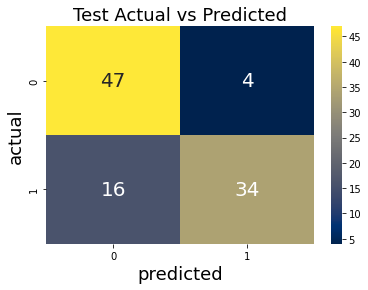

In [31]:
# Randomized datasets personally labeled by group

from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix

# Testing randomized pre-labeled test dataset
test = pd.read_csv('../datasets/validation_data.csv', lineterminator='\n')

# Cleaned & preprocessed
text_raw = test['text']
test_cleaned = text_raw.apply(clean).apply(clean2).apply(clean3)
test_seq = tokenizer.texts_to_sequences(test_cleaned)
test_padded = pad_sequences(test_seq, maxlen=60)

# Predictions
test['predictions'] = (model.predict(test_padded)>0.5).astype(int)

# Scores
acc = accuracy_score(test['is_credible'], test['predictions'])
f1 = f1_score(test['is_credible'], test['predictions'])
roc_auc = roc_auc_score(test['is_credible'], test['predictions'])

print('TEST RESULTS')
print(f'ACCURACY: {acc}')
print(f'F1 SCORE: {f1}')
print(f'ROC AUC: {roc_auc}')

# Confusion matrix
cm = confusion_matrix(test['is_credible'], test['predictions'])
sns.heatmap(cm, cmap= 'cividis', annot=True, fmt='g', annot_kws={'size':20})
plt.xlabel('predicted', fontsize=18)
plt.ylabel('actual', fontsize=18)
plt.title('Test Actual vs Predicted', fontsize=18)
plt.show()

TEST RESULTS
ACCURACY: 0.57
F1 SCORE: 0.6083788706739526
ROC AUC: 0.5700000000000001


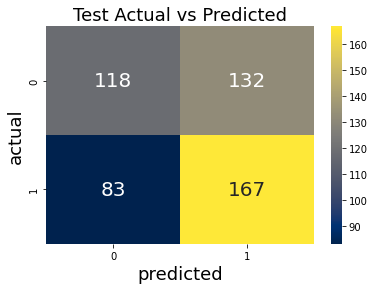

In [25]:
from tensorflow.keras.models import load_model

# Random wildfire dataset
model = load_model('pretrained_models/credibility_model.hdf5')

# Testing randomized pre-labeled test dataset
test = pd.read_csv('../datasets/california_wildfires.csv')

# Cleaned & preprocessed
text_raw = test['text']
test_cleaned = text_raw.apply(clean).apply(clean2).apply(clean3)
test_seq = tokenizer.texts_to_sequences(test_cleaned)
test_padded = pad_sequences(test_seq, maxlen=60)

# Predictions
test['predictions'] = (model.predict(test_padded)>0.5).astype(int)

# Scores
acc = accuracy_score(test['is_credible'], test['predictions'])
f1 = f1_score(test['is_credible'], test['predictions'])
roc_auc = roc_auc_score(test['is_credible'], test['predictions'])
cm = confusion_matrix(test['is_credible'], test['predictions'])

print('TEST RESULTS')
print(f'ACCURACY: {acc}')
print(f'F1 SCORE: {f1}')
print(f'ROC AUC: {roc_auc}')

# Confusion matrix
sns.heatmap(cm, cmap= 'cividis', annot=True, fmt='g', annot_kws={'size':20})
plt.xlabel('predicted', fontsize=18)
plt.ylabel('actual', fontsize=18)
plt.title('Test Actual vs Predicted', fontsize=18)
plt.show()